# Demonstration of Input mesh handling

## Import

In [2]:
from IPython.display import display, HTML
import base64

import tensorflow as tf
gpu = tf.config.get_visible_devices("GPU")[0]
tf.config.set_visible_devices(gpu, device_type="GPU")
tf.config.experimental.set_memory_growth(gpu, True)

import pyvista
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import vtk

import os
import math
from typing import List, Union, Tuple, Sequence
from pint import Quantity
from scipy.optimize import curve_fit
import cdtipy

import sys
sys.path.insert(0, "..")

import cmr_rnd_diffusion

C:\Users\Jonat\anaconda3\envs\tf29_pyvista\lib\site-packages\cdtipy\reconstruction.py:11: UserWarning: No matlab installation found!
  warnings.warn("No matlab installation found!")
C:\Users\Jonat\anaconda3\envs\tf29_pyvista\lib\site-packages\cdtipy\registration.py:10: UserWarning: No matlab installation found!
  warnings.warn("No matlab installation found!")


In [3]:
custom_camera_pos = [(0.138, -0.093, 0.102), (0.013, 0.022, -0.021), (-0.438, 0.393, 0.808)]
custom_theme = pyvista.themes.DefaultTheme()
custom_theme.background = 'white'
custom_theme.font.family = 'times'
custom_theme.font.color = 'black'
custom_theme.outline_color = "white"
custom_theme.edge_color = 'white'
custom_theme.transparent_background = True

## Refine mesh

Load data from list of vtk files (1 per time-stamp) and instantiate a CardiacMeshDataset

In [ ]:
files = [f'example_data/example_mesh/Displacements/Displ{i:03}.vtk' for i in range(0, 73, 1)]
timing = Quantity(np.loadtxt("example_data/example_mesh/PV_loop_reordered.txt")[:, 1], "ms")

original_mesh = cmr_rnd_diffusion.CardiacMeshDataset.from_list_of_meshes(files, timing[:len(files)],
                                                                         mesh_numbers=(4, 40, 30),
                                                                         time_precision_ms=3)

call refinement function

In [ ]:
refined_mesh = original_mesh.refine(longitudinal_factor=5, circumferential_factor=3, radial_factor=5)
refined_mesh.mesh.save(f"refined_mesh_({refined_mesh.mesh_numbers}).vtk")

Render animations of moving particle using the refined mesh starting at 80 ms (start systole)

In [ ]:
# pyvista.start_xvfb()  # If on Linux start Buffer manual to prevent memory corruption
refined_mesh.render_input_animation("refined_positions", scalar=None, 
                                    start=Quantity(80., "ms"),
                                    end=Quantity(280., "ms"),
                                    mesh_kwargs=dict(show_edges=True, opacity=0.3))
b64 = base64.b64encode(open("refined_positions.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

## Select a slice at given time:

In [9]:
refined_mesh = cmr_rnd_diffusion.CardiacMeshDataset.from_single_vtk("refined_mesh_((81, 60, 10)).vtk",
                                                                   mesh_numbers=(81, 60, 10))
slice_dict = dict(slice_thickness=Quantity(10, "mm"),
                  slice_normal=np.array((0., 0., 1.)),
                  slice_position=Quantity([0, 0, -3], "cm"),
                  reference_time = Quantity(105, "ms"))

temp = refined_mesh.select_slice(**slice_dict)
slice_mesh = cmr_rnd_diffusion.BaseDataset(temp, refined_mesh.timing)
# slice_mesh.render_input_animation("slice_trajectory", scalar=None, mesh_kwargs=dict(show_edges=True, opacity=0.3))
# b64 = base64.b64encode(open("slice_trajectory.gif",'rb').read()).decode('ascii')
# display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))
temp

UnstructuredGrid (0x276d17b3580)
  N Cells:	23218
  N Points:	5756
  X Bounds:	-3.295e-02, 3.538e-02
  Y Bounds:	-3.552e-02, 3.297e-02
  Z Bounds:	-3.332e-02, -1.937e-02
  N Arrays:	74

Rendering Mesh-Animation from 84.844 ms to 282.814 ms:   0%|          | 0/49 [00:00<?, ?it/s]

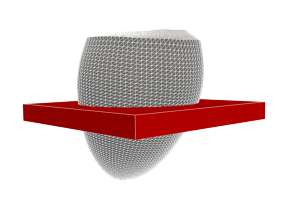

In [10]:
pyvista.close_all()
plotter = pyvista.Plotter(off_screen=True, theme=custom_theme, window_size=(800, 600))
plotter.camera_position = [(0.149, 0.162, -0.010), (0.0, 0.0, -0.028),(-0.065, -0.053, 0.997)]
bounding_box = Quantity([10, 10], "cm")
box_mesh = pyvista.Box(bounds=(-bounding_box[0].m_as("m")/2, bounding_box[0].m_as("m")/2,
                                 -bounding_box[1].m_as("m")/2, bounding_box[1].m_as("m") /2,
                                 -slice_dict["slice_thickness"].m_as("m")/2, slice_dict["slice_thickness"].m_as("m")/2))
box_mesh.translate(slice_dict["slice_position"].m_as("m"), inplace=True)
plotter.add_mesh(box_mesh, color="red", opacity=1, show_edges=True, edge_color="white")
plotter.add_mesh(refined_mesh.mesh, color="gray", show_scalar_bar=False, show_edges=True, opacity=1.)
img = plotter.screenshot("inlet.png")
plotter.close()

plotter = pyvista.Plotter(off_screen=True, theme=custom_theme, window_size=(900, 900))
plotter.add_text("A", position="upper_left")
plotter.camera_position = [(0.085, -0.077, 0.058), (-0.000, 0.002, -0.026), (-0.438, 0.393, 0.808)]
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img)
ax.axis("off")
f.tight_layout()
chart = pyvista.ChartMPL(f, size=(0.32, 0.32), loc=(0.69, 0.69))
chart.border_color = 'black'
chart.background_color = (1, 1, 1, 0)
plotter.add_chart(chart)
slice_mesh.render_input_animation("slice_trajectory", start=Quantity(slice_mesh.timing[23], "ms"),
                                  plotter=plotter, scalar=None,
                                  mesh_kwargs=dict(show_edges=False, opacity=0.9, edge_color="white", show_scalar_bar=False))



In [14]:
plotter.camera_position

[(0.08514844333275903, -0.07674074668631674, 0.05757323144698476),
 (-0.00022823858787476142, 0.001805800680666358, -0.026437423562918887),
 (-0.4381847338061574, 0.39316575430552486, 0.8083407874780256)]

## Load reference mesh that contains the fibre-orientations

In [ ]:
reference_mesh = pyvista.read("example_data/example_mesh/ED_reference_mesh.vtk")
slice_mesh.probe_reference(reference_mesh, ["fibers", "sheets"], reference_time=None)
slice_mesh.transform_vectors(slice_mesh.timing, ["fibers", "sheets"], reference_time=None, rotation_only=True)

slice_mesh.render_input_animation("vectors_slice_fiber", start=Quantity(0, "ms"), end=None, vector="fibers",
                                   mesh_kwargs=dict(opacity=0.4), vector_kwargs=dict(mag=5e-3, color="red"))
slice_mesh.render_input_animation("vectors_slice_sheet", start=Quantity(0, "ms"), end=None, vector="sheets",
                                   mesh_kwargs=dict(opacity=0.4), vector_kwargs=dict(mag=5e-3, color="blue"))
b64 = base64.b64encode(open("vectors_slice_fiber.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [ ]:
reference_mesh = pyvista.read("example_data/example_mesh/ED_reference_mesh.vtk")
refined_mesh.probe_reference(reference_mesh, ["fibers", "sheets"], reference_time=None)
refined_mesh.transform_vectors(refined_mesh.timing, ["fibers"], reference_time=None, rotation_only=True)

refined_mesh.render_input_animation("vectors", start=Quantity(0, "ms"), end=None, vector="fibers",
                                    mesh_kwargs=dict(opacity=0.4), vector_kwargs=dict(mag=5e-3, color="red"))

In [ ]:
t, fibers_over_time = slice_mesh.get_field("fibers")

## Sample diffusion Tensors and animate

In [ ]:
refined_mesh = cmr_rnd_diffusion.CardiacMeshDataset.from_single_vtk("refined_mesh_((121, 150, 16)).vtk",
                                                                   mesh_numbers=(16, 121, 150))
refined_mesh.compute_local_basis(Quantity(0., "ms"))
refined_mesh.compute_cylinder_coords(Quantity(0., "ms"))

slice_dict = dict(slice_thickness=Quantity(10, "mm"),
                  slice_normal=np.array((0., 0., 1.)),
                  slice_position=Quantity([0, 0, -3], "cm"),
                  reference_time = Quantity(105, "ms"))

temp = refined_mesh.select_slice(**slice_dict)
slice_mesh = cmr_rnd_diffusion.DiffusionDataset(temp, refined_mesh.timing)

# Idealized random angles
slice_mesh.random_angles(helix_kw=dict(angle_range=(65, -65)),
                         e2a_kw=dict(down_sampling_factor=15 ** 2., seed_fraction=0.15, prob_high=0.4, high_angle_value=90., low_angle_value=1.,
                                     kernel_width=0.15, distance_weights=(0.7, 1., 10.), verbose=True))

# Angles from reference
# reference_mesh = pyvista.read("example_data/example_mesh/ED_reference_mesh.vtk")
# loc_b = np.stack([reference_mesh[k] for k in ("e_t", "e_c", "e_l")], axis=-1)
# reference_mesh["ha"] = cdtipy.angulation.helix_angle(reference_mesh["fibers"], loc_b)
# reference_mesh["e2a"] = cdtipy.angulation.sheetlet_angle(reference_mesh["fibers"], reference_mesh["sheets"], loc_b)
# slice_mesh.angles_from_ref(reference_mesh, Quantity(105, "ms"))
# np.sum(np.logical_not(np.isfinite(slice_mesh.mesh["e2aref"]))), np.sum(np.logical_not(np.isfinite(slice_mesh.mesh["haref"])))

In [ ]:
with tf.device("CPU:0"):
    sampler = cmr_rnd_diffusion.sampling.MCRejectionSampler.from_savepath(f"sampler_diffusion_healthy_exp.npz",
                                    sampling_method=cmr_rnd_diffusion.sampling.exponentially_sample_simplex) 
    eigen_value_pool = sampler.get_samples(40000)
    np.save("example_data/ev_pool.npy", eigen_value_pool)

In [ ]:
# slice_mesh.sample_tensors(np.repeat(np.load("example_data/ev_pool.npy").astype(np.float32), 1, axis=0),
#                          interpolation_kwargs=dict(seed_fraction=0.2, distance_weights=(1., 0.8, 10.), kernel_variance=0.1))
slice_mesh.rotate_tensors(Quantity(slice_mesh.timing[23:], "ms"), Quantity(105, "ms"))

In [ ]:
plotter = pyvista.Plotter(off_screen=True, theme=custom_theme, window_size=(1500, 900))
plotter.add_text("B", position="upper_left")
plotter.camera_position = custom_camera_pos

r_temp = slice_mesh.get_positions_at_time(Quantity(105, "ms"))[:, 2] 
indices = np.where(np.logical_and(r_temp > -0.032, r_temp < -0.028))
slice_mesh.animate_tensors(slice_mesh.timing[23:], indices=indices, file_name="tensor_animation.gif", plotter=plotter, plot_glyphs=True)

In [ ]:
b64 = base64.b64encode(open("tensor_animation.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

## combine gifs

In [13]:
import imageio

gif_1 = imageio.get_reader("slice_trajectory.gif")
gif_2 = imageio.get_reader("tensor_animation.gif")

combined_gif = imageio.get_writer('combined.gif')

for f1, f2 in zip(gif_1, gif_2):
    combined_gif.append_data(np.concatenate([f1, f2], axis=1))

gif_1.close()
gif_2.close()    
combined_gif.close()

In [17]:
gif_1 = imageio.get_reader("combined.gif")
gif_2 = imageio.get_reader("animation.gif")
combined_gif = imageio.get_writer('combined2.gif')

for f1, f2 in tqdm(zip(gif_1, gif_2), total=len(gif_1)):
    combined_gif.append_data(np.concatenate([f1, f2], axis=0))

gif_1.close()
gif_2.close()    
combined_gif.close()  

  0%|          | 0/49 [00:00<?, ?it/s]